In [1]:
!pip install -r "/content/drive/MyDrive/requirements.txt"

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import mahotas

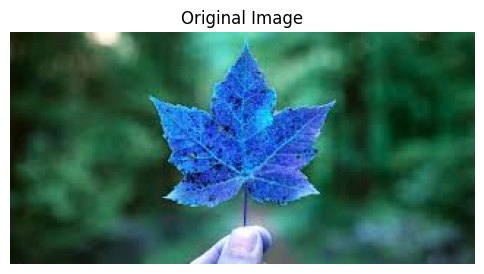

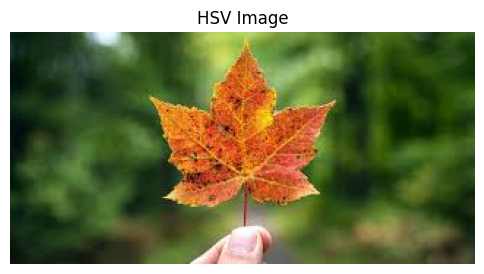

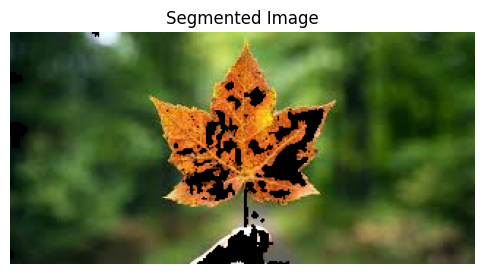

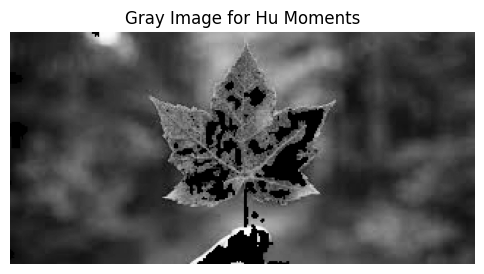

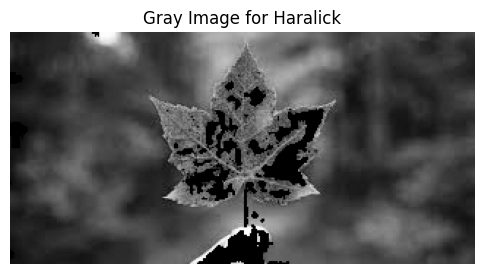

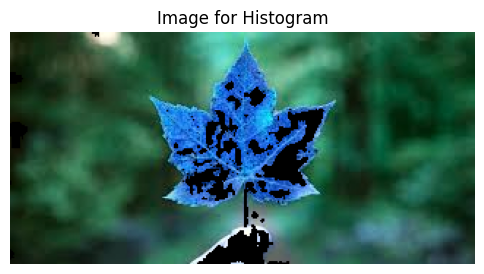

In [4]:
class Inference:
    def image_classification(self, image):
        # Get the Model
        img_model = self.get_model()

        # Process the image
        processed_img = self.process_image(image)

        # Reshape to 2D
        processed_img = processed_img.reshape(1, -1)

        # Predict
        y_predict = img_model.predict(processed_img)

        del img_model

        # 0 - Health / 1 - Disease
        return y_predict[0]

    def process_image(self, image):
        # Convert RGB to BGR
        rgb_bgr = self.rgb_to_bgr(image)

        # Display the original image
        self.display_image(image, "Original Image")

        # Convert BGR to HSV
        bgr_hsv = self.bgr_to_hsv(rgb_bgr)
        self.display_image(cv2.cvtColor(bgr_hsv, cv2.COLOR_HSV2RGB), "HSV Image")

        # Image Segmentation
        img_segment = self.img_segmentation(rgb_bgr, bgr_hsv)
        self.display_image(img_segment, "Segmented Image")

        # Call for Global Feature Descriptors
        fv_hu_moments = self.fd_hu_moments(img_segment)
        fv_haralick = self.fd_haralick(img_segment)
        fv_histogram = self.fd_histogram(img_segment)

        # Concatenate
        processed_image = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        return processed_image

    def get_model(self):
        model_file = open("/content/drive/MyDrive/disease-classification.pkl", "rb")
        model = pickle.load(model_file)
        model_file.close()
        return model

    def rgb_to_bgr(self, image):
        rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return rgb_img

    def bgr_to_hsv(self, rgb_img):
        hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
        return hsv_img

    def img_segmentation(self, rgb_img, hsv_img):
        lower_green = np.array([25, 0, 20])
        upper_green = np.array([100, 255, 255])
        healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
        result = cv2.bitwise_and(rgb_img, rgb_img, mask=healthy_mask)

        lower_brown = np.array([10, 0, 10])
        upper_brown = np.array([30, 255, 255])
        disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
        disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)

        final_mask = healthy_mask + disease_mask
        final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
        return final_result

    def fd_hu_moments(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        feature = cv2.HuMoments(cv2.moments(image)).flatten()
        self.display_image(image, "Gray Image for Hu Moments")
        return feature

    def fd_haralick(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.display_image(gray, "Gray Image for Haralick")
        haralick = mahotas.features.haralick(gray).mean(axis=0)
        return haralick

    def fd_histogram(self, image, mask=None):
        bins = 8
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        self.display_image(cv2.cvtColor(image, cv2.COLOR_HSV2RGB), "Image for Histogram")
        return hist.flatten()

    def display_image(self, image, title):
        """Displays an image using matplotlib in a Jupyter Notebook."""
        plt.figure(figsize=(6, 6))
        if len(image.shape) == 3:  # Color image
            plt.imshow(image)
        else:  # Grayscale image
            plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

# Example Usage
# Assuming `image` is your input image (loaded using cv2.imread or similar)
inference = Inference()
image = cv2.imread("/content/drive/MyDrive/deceased.jpg")
result = inference.image_classification(image)

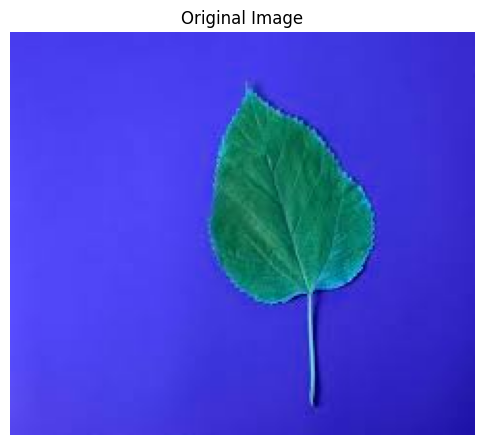

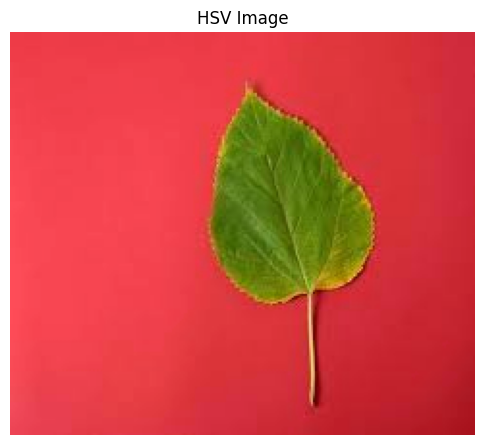

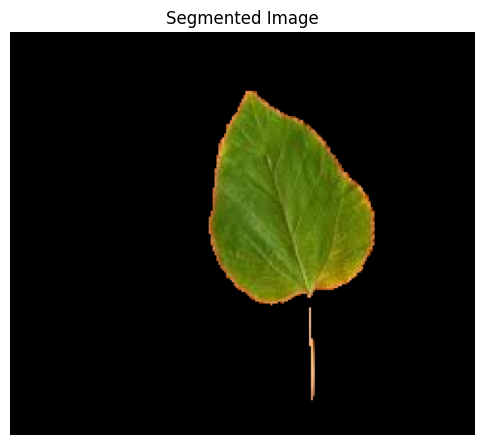

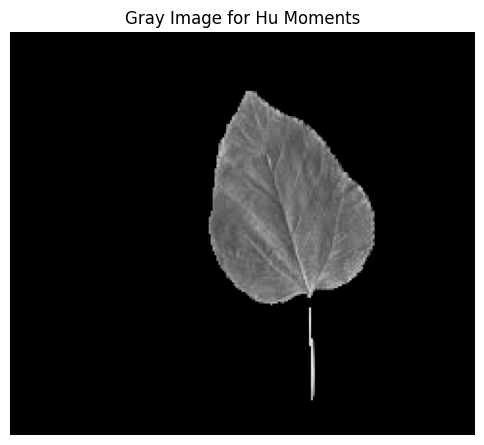

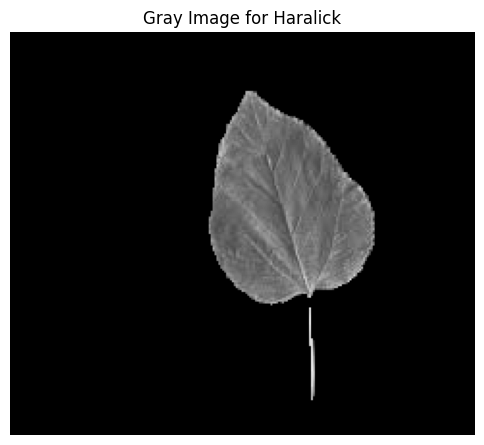

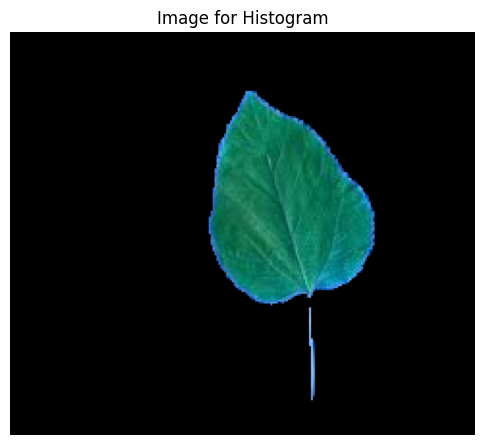

In [5]:
inference = Inference()
image = cv2.imread("/content/drive/MyDrive/healthy.jpg")
result = inference.image_classification(image)